@2025-2-21用于分析行为数据和神经数据相关性
输入
+ 根据神经数据时间戳对齐的行为数据
+ calcium trace数据

In [1]:
import sys
sys.path.append(r"D:\data analysis\code\WBI_analysis")  # 例如 r"C:\Users\YourName\Project"
import AnalysisMethod

In [2]:
import cv2
import os
import pandas as pd
import bisect
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.ndimage import grey_opening,grey_closing
from matplotlib.gridspec import GridSpecFromSubplotSpec
import AnalysisMethod as am
from sklearn.cluster import AgglomerativeClustering
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib as mpl
import warnings
import argparse
from scipy.signal import correlate
from scipy.stats import ttest_1samp
# from statsmodels.stats.multitest import multipletests
from scipy.ndimage import gaussian_filter1d,binary_closing, binary_opening
# from matplotlib.gridspec import GridSpec
warnings.filterwarnings('ignore')
from tifffile import imread
from scipy.stats import sem
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import ttest_rel, shapiro

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 96
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.bbox'] = 'tight'

In [3]:
def get_start_points(forward_reversal_series):
    # 创建一个 DataFrame，只包含原始列，方便处理
    df = pd.DataFrame({'forward_reversal_series': forward_reversal_series})
#     df['rev_start'] = 0

    # 差分找变化点
    df['diff_qr'] = df['forward_reversal_series'].diff()
    df['diff_qr'].plot()
#     plt.plot(diff_qr)
#     print(len(df.loc[diff_qr == 1, 'rev_start']), len(df.loc[diff_qr == 1, 'rev_start'])/len(df))
    # 标记起始和结束
    df.loc[:,'rev_start'] = np.nan
    df.loc[df['diff_qr'] == 1, 'rev_start'] = 1
    df.loc[df['diff_qr'] == -2, 'rev_start'] = 2    # 从nan转到reverse
    df.loc[df['diff_qr'] == -1, 'rev_start'] = 3
    df.loc[df['diff_qr'] == -3, 'rev_start'] = 4    # 从nan转到forward
    # 特殊情况处理：开头或结尾就是 1
#     if df['quick_reversal'].iloc[0] == 1:
#         df.loc[df.index[0], 'quick_reversal_point'] = 1
#     if df['quick_reversal'].iloc[-1] == 1:
#         df.loc[df.index[-1], 'quick_reversal_point'] = 2

    return df['rev_start'].values

def Opening_Closing(vector,structure_size_open=10, structure_size_close=5):
    '''利用开操作删除和合并后退
    vector: 一维向量
    structure_size的第一和第二个值分别控制开和闭的大小'''
    # 可视化重定向的位置，找到索引
#     vector = df_PCA_motion.forward.values

    # 将一维向量扩展为二维（例如 1 行或 1 列）
    heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
    print(heatmap_data)
    # Define two colors
    colors = ['blue', 'yellow']
    # Create a ListedColormap
    two_color_cmap = ListedColormap(colors)


#     # 绘制热图
#     plt.figure(figsize=(20, 1))  # 设置热图大小
#     plt.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
#     plt.colorbar(label='Value')  # 添加颜色条
#     plt.xticks([])  # 设置x轴刻度
#     plt.yticks([])  # 隐藏y轴刻度
#     plt.title("Before opening")
#     plt.show()

    # Define the size of the structuring element
#     structure_size_open = 10
    # Perform opening
    '''这里opening的效果是合并！'''
    opened_vector = grey_opening(heatmap_data, size=structure_size_open)

    # Perform closing
    '''这里的close的效果是擦除！'''
    vector = grey_closing(opened_vector, size=structure_size_close)

#     plt.figure(figsize=(20, 1))  # 设置热图大小
#     plt.imshow(vector, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
#     plt.colorbar(label='Value')  # 添加颜色条
#     plt.title('Removed small turnings')
#     plt.xticks()  # 设置x轴刻度
#     plt.yticks([])  # 隐藏y轴刻度
#     # plt.title("Heatmap of 1D Vector")
#     plt.show()
    return vector

def plot_custom_timeseries(
    df,
    time_col,
    line_cols=None,
    line_color_by_col=None,
    scatter_col=None,
    colorbar1_col=None,
    colorbar2_col=None,
    nanbar1_col=None,
    vertical_line_col=None,
    triangle_times=None,
    plot_line=None,
    plot_scatter=None,
    plot_colorbar1=None,
    plot_colorbar2=None,
    plot_colorbar3=None,
    plot_vertical_lines=None,
    plot_triangles=None,
    figsize=(20, 4),
    title=None,
    time_range=None
):
    def col_should_plot(col, flag):
        if flag is None:
            return col is not None and col in df.columns
        return flag

    if time_range:
        start, end = time_range
        df = df[(df[time_col] >= start) & (df[time_col] <= end)].reset_index(drop=True)

    draw_bar1 = col_should_plot(colorbar1_col, plot_colorbar1)
    draw_bar2 = col_should_plot(colorbar2_col, plot_colorbar2)
    draw_bar3 = col_should_plot(nanbar1_col, plot_colorbar3)
    num_bars = int(draw_bar1) + int(draw_bar2) + int(draw_bar3)

#     fig, ax_main = plt.subplots(figsize=figsize, constrained_layout=True)
    fig,ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)
#     if num_bars > 0:
    fig.set_constrained_layout(False)
    gs = GridSpec(len(line_cols)+1, 1, height_ratios=[1.0]*len(line_cols)+[0.3 * num_bars], wspace=0.3, hspace=0.25, figure=fig)
    # 可能画多个折线图
    ax_bar = fig.add_subplot(gs[-1], sharex=ax)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])                  # 去除刻度
    ax.set_yticklabels([])            # 去除刻度标签
    ax.tick_params(axis='y', left=False)  # 去除刻度线
    # Plot line
    i = 0
    for line_col in line_cols:
        ax_main = fig.add_subplot(gs[i])
        if isinstance(line_col, str):
            line_col_list = [line_col]
        else:
            line_col_list = line_col

        for col in line_col_list:
            if line_color_by_col and line_color_by_col in df.columns:
                
                # 分段上色
                segment_time, segment_value, current_color = [], [], None
                handles_drawn = {'red': False, 'blue': False}

                for t, y, c in zip(df[time_col], df[col], df[line_color_by_col]):
                    if current_color is None:
                        current_color = c
                    if c != current_color:
                        if segment_time:
                            color = 'red' if current_color == 1 else 'blue'
                            label = 'reversal' if color == 'red' and not handles_drawn['red'] else None
                            ax_main.plot(segment_time, segment_value, color=color)
                            handles_drawn[color] = True
                        segment_time, segment_value = [t], [y]
                        current_color = c
                    else:
                        segment_time.append(t)
                        segment_value.append(y)
                if segment_time:
                    color = 'red' if current_color == 1 else 'blue'
                    label = 'reversal' if color == 'red' and not handles_drawn['red'] else None
                    ax_main.plot(segment_time, segment_value, color=color)
            else:
                ax_main.plot(df[time_col], df[col], lw=2)
            if 'smoothed_' in col:
                col = col.replace('smoothed_','')
                ax_main.set_ylabel('\n'.join(col.split('_')),rotation=0, labelpad=20)
            else:
                ax_main.set_ylabel('\n'.join(col.split('_')),rotation=0, labelpad=20)
            if time_range:
                ax_main.set_xlim(time_range)
            else:
#                 print(df[time_col].min(), df[time_col].max())
                ax_main.set_xlim(df[time_col].min(), df[time_col].max())
            ax_main.set_xticks([])
            
            # Triangle markers
            if len(triangle_times) and (plot_triangles is None or plot_triangles):
                y_min, y_max = ax_main.get_ylim()
                triangle_y = y_max + 0.05 * (y_max - y_min)
                for t in triangle_times:
                    ax_main.plot(df.loc[t,time_col], triangle_y, marker='v', color='purple', markersize=8)
                    ax_main.axvline(x=df.loc[t,time_col], color='black', linestyle='--', linewidth=1)
                ax_main.set_ylim(y_min, triangle_y + 0.1 * (y_max - y_min))
        i += 1

    # Plot scatter
    if col_should_plot(scatter_col, plot_scatter):
        ax_main.scatter(df[time_col], df[scatter_col], color='r', s=2, label=scatter_col)

    # Vertical lines
    if col_should_plot(vertical_line_col, plot_vertical_lines):
        for vt in df[df[vertical_line_col] == 1][time_col]:
            ax_main.axvline(x=vt, color='green', linestyle='--', linewidth=1)

    

    

    # Colorbar
    handles, labels = ax_main.get_legend_handles_labels()
    if ax_bar:
        bar_data = []
        if draw_bar3:
            nan_mask = df[nanbar1_col].isna().values
            bar_data.append((np.where(nan_mask, 1, 0)[np.newaxis, :], mcolors.ListedColormap(['black', 'red'])))
        if draw_bar2:
            vals2 = df[colorbar2_col].fillna(0).astype(int).values[np.newaxis, :]
            bar_data.append((vals2, mcolors.ListedColormap(['black', 'yellow'])))
        if draw_bar1:
            vals1 = df[colorbar1_col].fillna(0).astype(int).values[np.newaxis, :]
            bar_data.append((vals1, mcolors.ListedColormap(['black', 'yellow', 'red'])))

        bar_height = 1.0 / num_bars
        for i, (vals, cmap) in enumerate(bar_data):
            extent = [df[time_col].iloc[0], df[time_col].iloc[-1], i * bar_height, (i + 1) * bar_height]
            ax_bar.imshow(vals, aspect='auto', cmap=cmap, extent=extent)

        bar_labels = []
        if draw_bar3: bar_labels.append('untrust')
        if draw_bar2: bar_labels.append('reversal(after)')
        if draw_bar1: bar_labels.append('reversal(before)')

        ax_bar.set_yticks([(i + 0.5) / num_bars for i in range(num_bars)])
        ax_bar.set_yticklabels(bar_labels)
        ax_bar.set_ylim(0, 1)
        ax_bar.tick_params(left=False)
        ax_bar.set_xlabel('Time')

        # Legend patch
        patches = []
        if draw_bar1: 
            patches.append(Patch(color='yellow', label='reversal'))
        if draw_bar2: patches.append(Patch(color='red', label='untrusted frames'))
        handles += patches
        labels += [p.get_label() for p in patches]

    if handles:
#         ax_main.legend(handles=handles, labels=labels, loc='upper right')
        ax_main.legend(loc='upper left',handles=handles, labels=labels, bbox_to_anchor=(1.01, 0.85), borderaxespad=0.)

#     ax_main.set_ylabel('Value')
    
#     plt.tight_layout()
    return fig, ax_main


# 行为数据导入以及事件分割

In [4]:
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\no_binary\20250116_4.5g-ov_05'

# 行为数据导入
'''激光段的行为数据，帧率为30Hz左右'''
mot_mid_cut = [f for f in os.listdir(p_f) if 'mot_midline_cut' in f][0]
df_motion_cut = pd.read_csv(os.path.join(p_f, mot_mid_cut))

# 行为数据进行平滑和分割前进后退
# 对数据进行平滑
# 平滑速度
window_size = 15
# 计算移动平均值
df_motion_cut['smoothed_speed'] = df_motion_cut['speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑角速度
window_size = 15
# 计算移动平均值
df_motion_cut['smoothed_agl_speed'] = df_motion_cut['agl_speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑ctx
window_size = 15
# 计算移动平均值
df_motion_cut['smoothed_CTX'] = df_motion_cut['CTX_left'].rolling(window=window_size, min_periods=1).mean()

In [5]:
# # 检查angle_m分布
# df_motion_cut['angle_m'].hist()

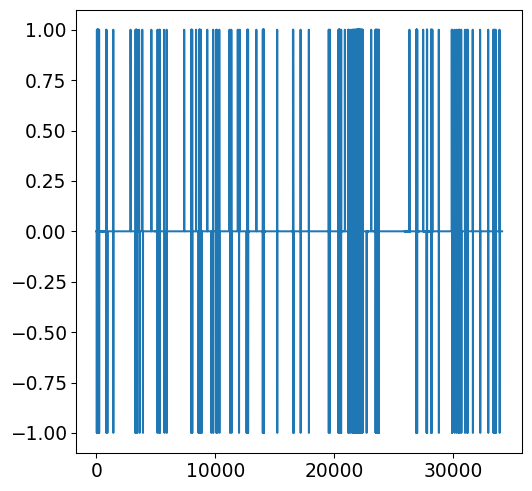

In [6]:
# 根据角速度分隔前进后退状态
agl_threshold = 100
df_motion_cut.loc[:,'forward'] = 0
df_motion_cut.loc[df_motion_cut['angle_m']>=agl_threshold,'forward'] = 1
df_motion_cut.loc[df_motion_cut['angle_m'].isna(),'forward'] = np.nan
# df_PCA_motion.loc[df_PCA_motion['choose_frame']!=1,'forward'] = 3
label_rev = get_start_points(df_motion_cut['forward'].values)
df_motion_cut['rev_start'] = label_rev

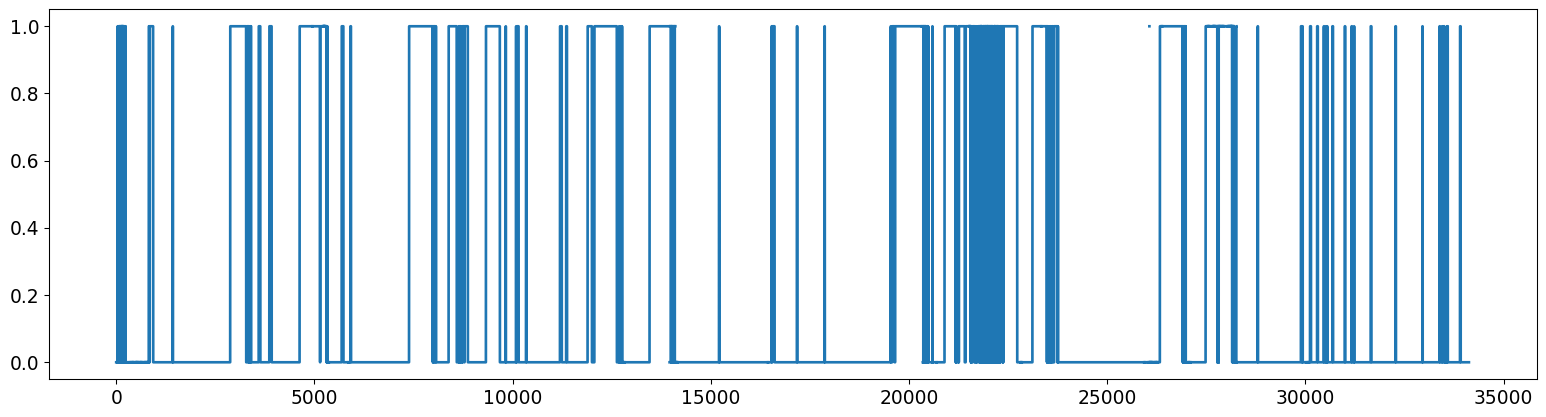

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df_motion_cut['forward'], lw=2)

In [8]:
# 对行为数据分割的前进后退进行开闭操作
# 开操作：去除噪声，structure_size = 0.65s * 30 = 19.5 ~ 20
# 闭操作：合并两个 reversal: structure_size = 40
structure = np.ones(50)
opened_first = binary_opening(df_motion_cut['forward'].astype(bool), structure=structure).astype(int)
structure = np.ones(50)
closed = binary_closing(opened_first, structure=structure).astype(int)

# 经过一轮开闭操作后的序列
df_motion_cut['forward_opcl'] = closed
df_motion_cut.loc[df_motion_cut['angle_m'].isna(),'forward_opcl'] = 3  # 还是将没有通过筛选的处理为3，灰色

Index([  846,  2876,  3863,  4627,  7388,  8386,  8788,  9327, 11892, 12063,
       13455, 16554, 19578, 20896, 21257, 22302, 23113, 23661, 26328, 27482],
      dtype='int64') 
 Index([  932,  3278,  3921,  5305,  7984,  8590,  8870,  9678, 12000, 12629,
       16608, 21178, 21557, 22728, 23480, 23741, 26908, 28150],
      dtype='int64')


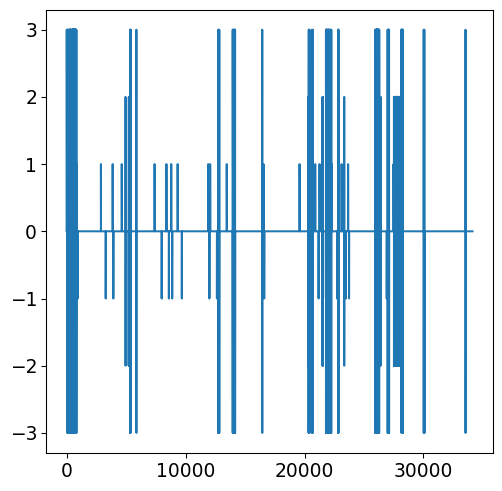

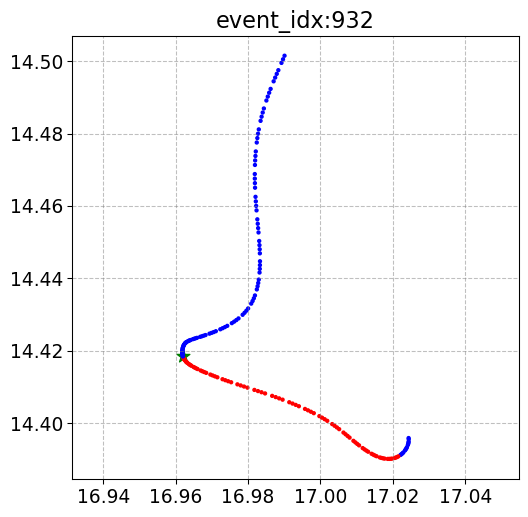

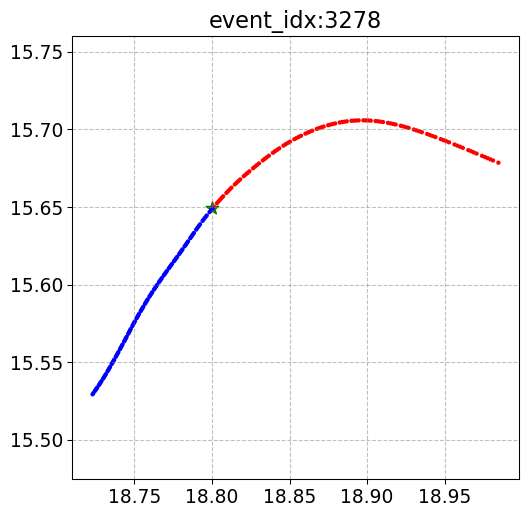

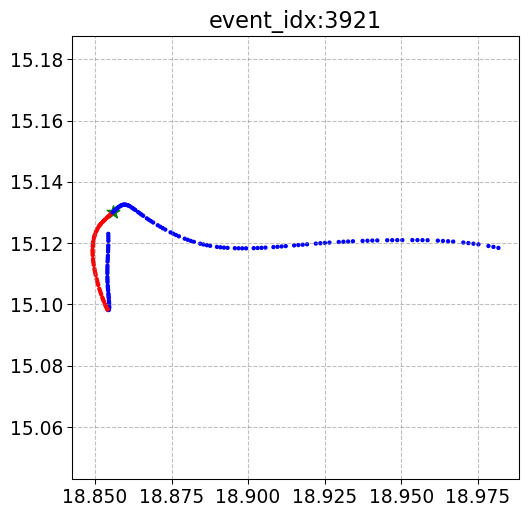

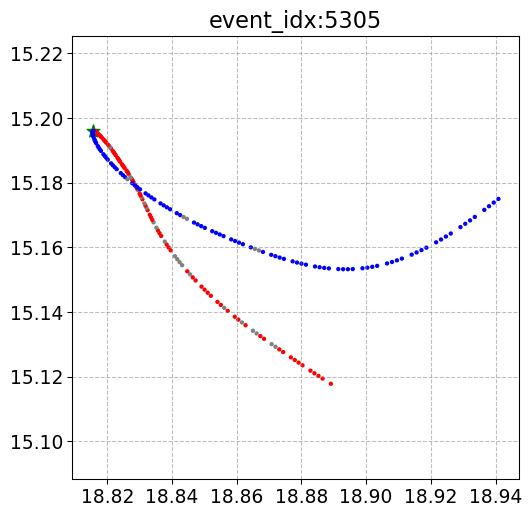

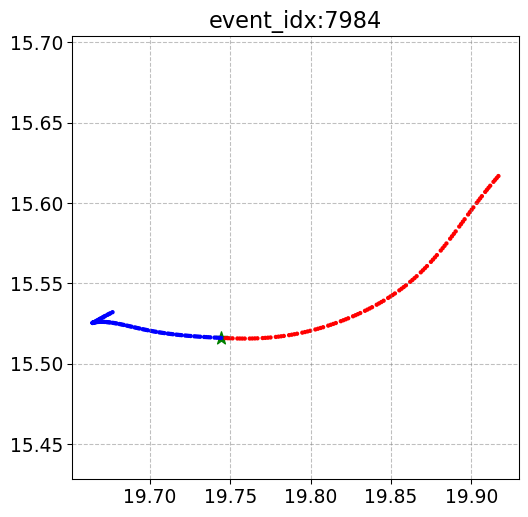

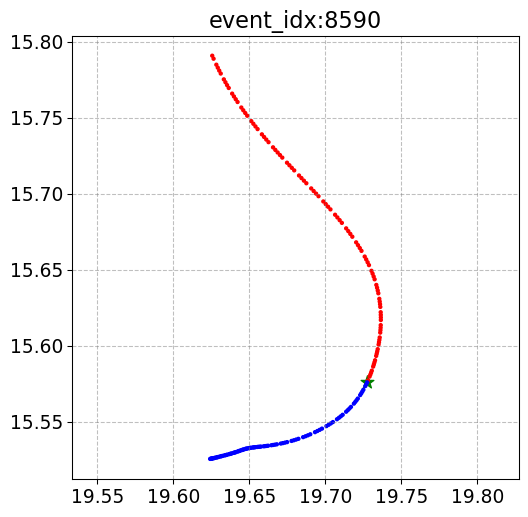

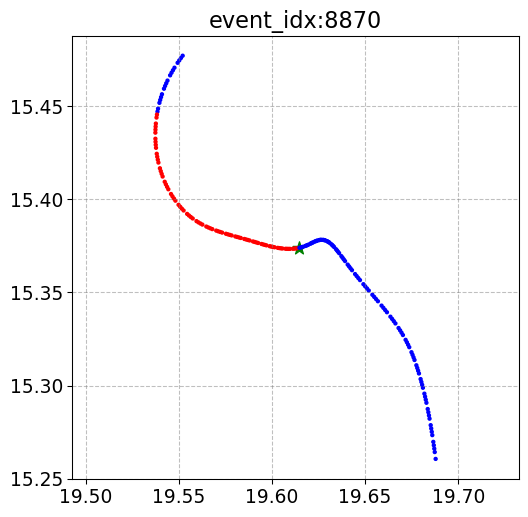

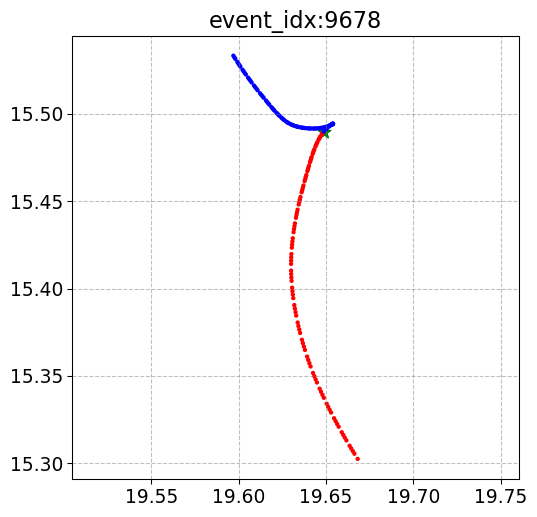

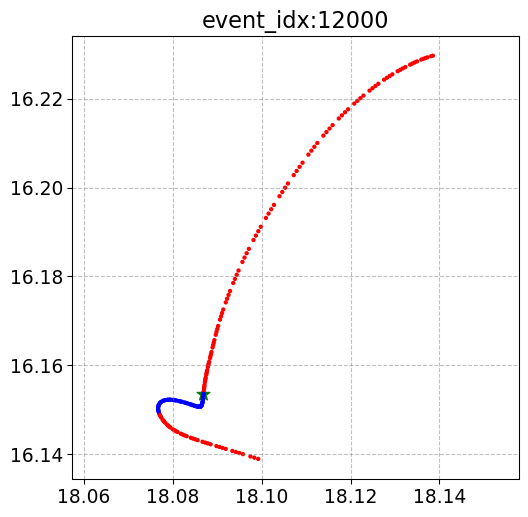

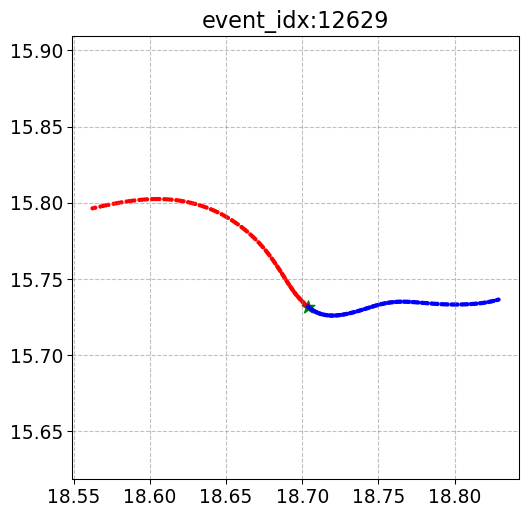

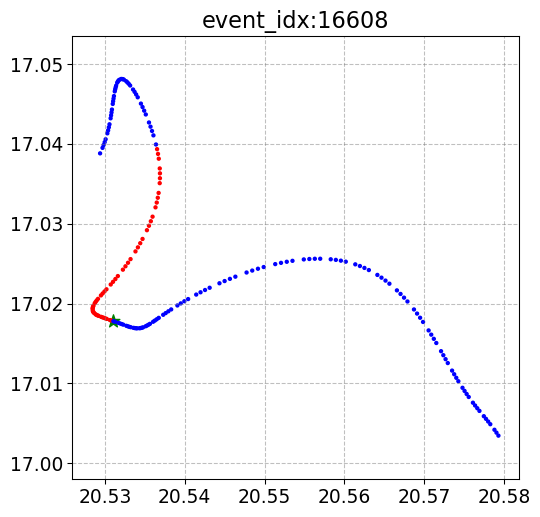

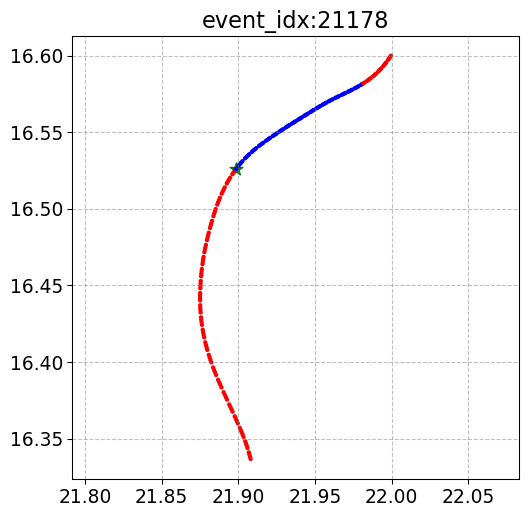

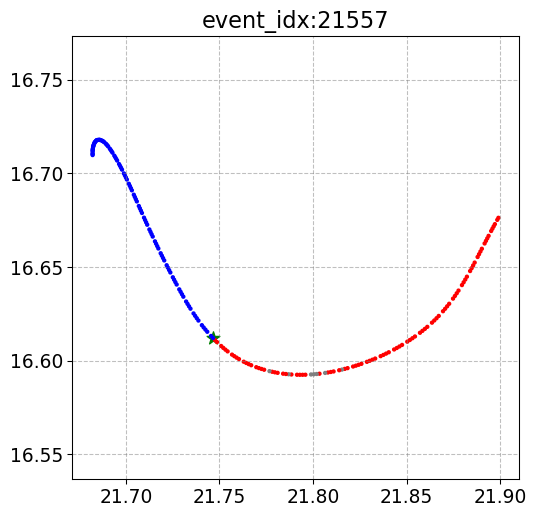

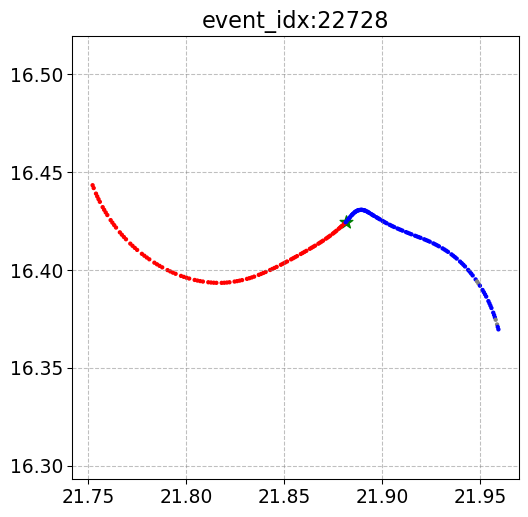

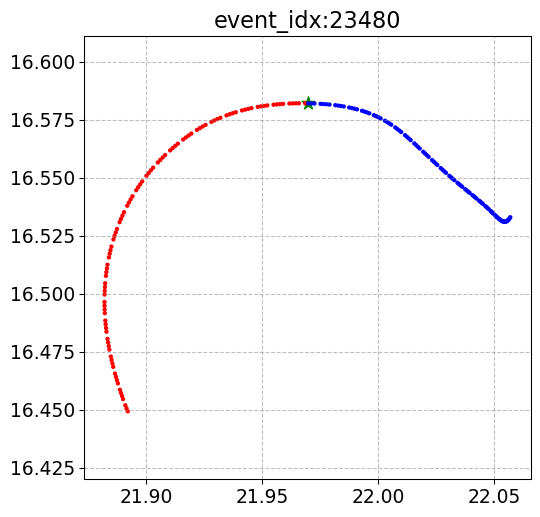

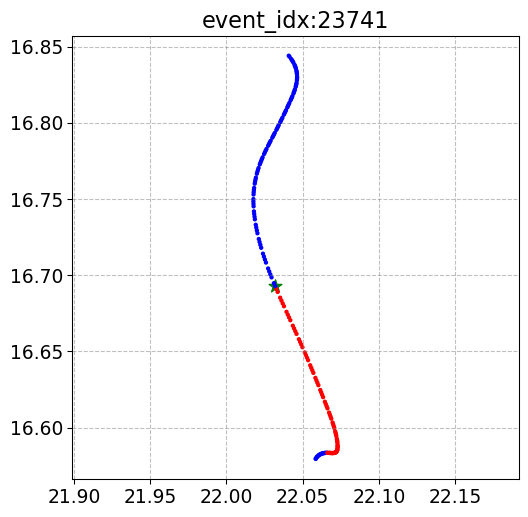

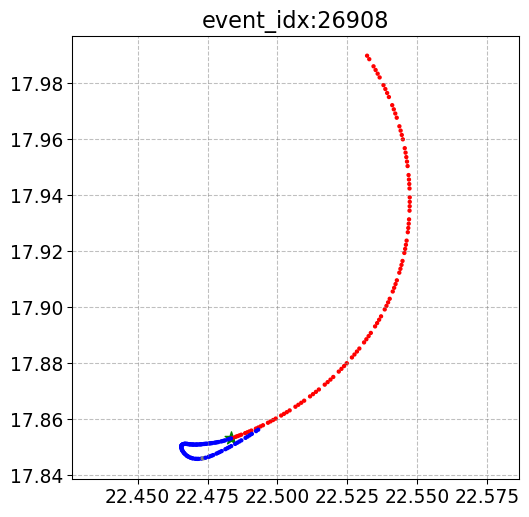

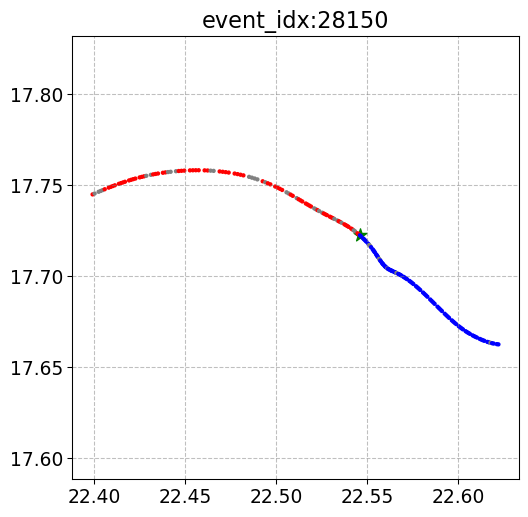

In [9]:
# 开闭后对节点进行检查
label_rev = get_start_points(df_motion_cut['forward_opcl'].values)
df_motion_cut['rev_start_opcl'] = label_rev

rev_start_idx = df_motion_cut[df_motion_cut['rev_start_opcl']==1].index
rev_end_idx = df_motion_cut[df_motion_cut['rev_start_opcl']==3].index
print(rev_start_idx,'\n',rev_end_idx)

event_idx_ls = rev_end_idx
draw_window = 100  # 在节点前后画图的时间窗

for i, idx in enumerate(event_idx_ls):
    start_idx = idx-draw_window
    end_idx = idx+draw_window
    df_i = df_motion_cut.loc[start_idx:end_idx, :]
    plt.figure()
    plt.grid(ls='dashed', c = 'grey', alpha = 0.5)
    plt.axis('equal')
    plt.title('event_idx:'+str(idx))
    plt.scatter(df_i.loc[idx,'X'], df_i.loc[idx,'Y'], s = 100, marker = '*', color='green')
    colors = df_i['forward_opcl'].map({0: 'blue', 1: 'red', 3:'grey'})
    plt.scatter(df_i['X'], df_i['Y'],c = colors ,s=5)
    plt.show()

In [10]:
# # 验证后为了可视化方便，删除除了指定节点以外的其它reverse
# start_sel  = sorted(rev_start_idx)
# end_sel = sorted(rev_end_idx)
# # 新生成的一列，只保留(选中的后退段的)0和1，不包括删除帧3
# df_motion_cut.loc[:,'forward_sel'] = 0
# for i, s_idx in enumerate(start_sel):
#     # 对于每一个start_index，找到其对应的end_index
#     nearest_end = end_sel[bisect.bisect_left(end_sel, s_idx)]
# #     print(s_idx, nearest_end)
#     # 根据这两个index将中间的部分变成1
#     df_motion_cut.loc[s_idx+1:nearest_end,'forward_sel'] = 1

In [11]:
def label_event_segments(df, start_indices, event_col = "forward_opcl",
                          accept_ab_end = True,
                          output_col='forward_sel'):
    """
    根据开始和结束标记对DataFrame进行段落标注。
    注意这个代码需要匹配对于forward-reverse transition的四种情况的标记语法

    参数：
    - start_flags：开始的标记值列表
    - accept_ab_end: 接收异常结尾
    - output_col：新列的名字
    - debug：是否打印调试信息
    """
    # 初始化输出列
    df[output_col] = 0

    # 获取 end 索引及标签

    end_nor_indices = df[df['rev_start_opcl']==3].index
    end_abnor_indices = df[df['rev_start_opcl']==4].index
    
    for s_idx in start_indices:
        print(s_idx)
        nearest_nor_end = end_nor_indices[bisect.bisect_left(end_nor_indices, s_idx)]
        nearest_abnor_end = end_abnor_indices[bisect.bisect_left(end_abnor_indices, s_idx)]
        print(nearest_nor_end, nearest_nor_end)
#         if not end_candidates:
#             if debug:
#                 print(f'⚠ No end found for start at {s_idx}')
#             continue
        if nearest_abnor_end <= nearest_nor_end:
            # 异常结束
            if accept_ab_end:
                df.loc[s_idx+1:nearest_abnor_end,output_col] = 1
            else:
                pass
        else:
            df.loc[s_idx+1:nearest_nor_end,output_col] = 1
    return df

In [12]:
# 0116-05 start point删除: 8788,21257,22302,23661,27812
rev_start_idx = [ 846,  2876,  3863,  4627,  7388,  8386,  9327, 11892, 12063,
       13455, 16554, 19578, 20896, 23113, 26328, 27482]

In [13]:
df_motion_cut_sel = label_event_segments(df_motion_cut, rev_start_idx, event_col = "forward_opcl",
                          accept_ab_end = True,
                          output_col='forward_sel')

846
932 932
2876
3278 3278
3863
3921 3921
4627
5305 5305
7388
7984 7984
8386
8590 8590
9327
9678 9678
11892
12000 12000
12063
12629 12629
13455
16608 16608
16554
16608 16608
19578
21178 21178
20896
21178 21178
23113
23480 23480
26328
26908 26908
27482
28150 28150


<Axes: >

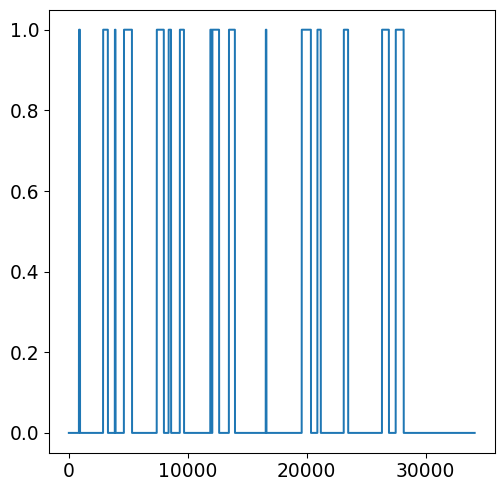

In [14]:
df_motion_cut_sel['forward_sel'].plot()

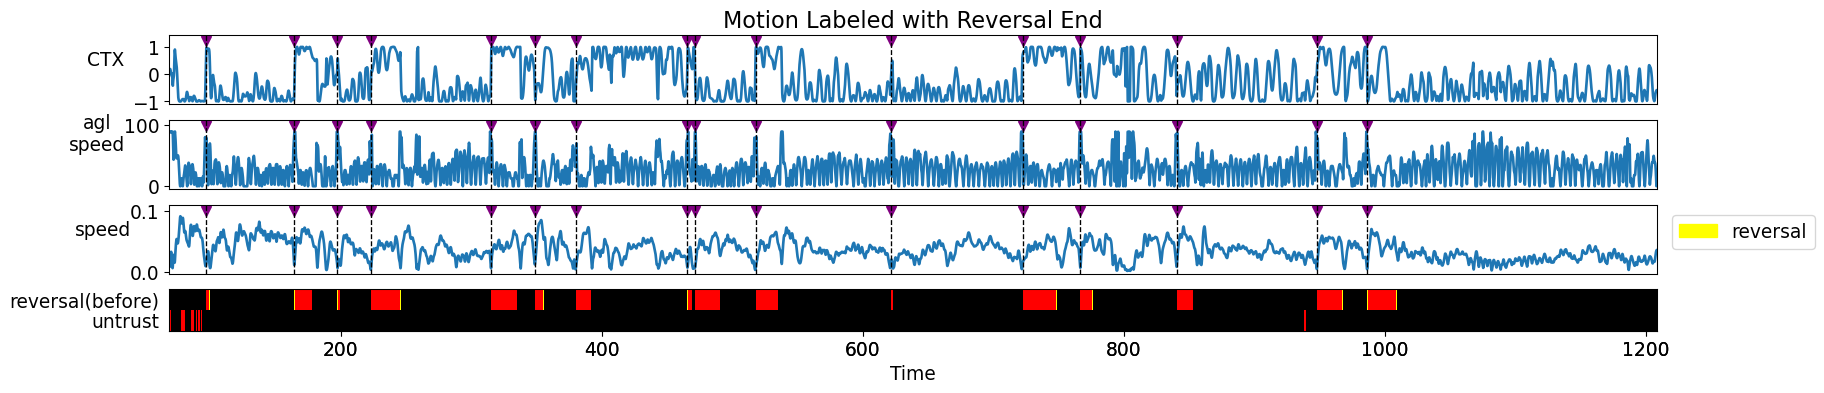

In [15]:
# 可视化验证
fig, ax = plot_custom_timeseries(
    df=df_motion_cut_sel,
    time_col='Time',
    line_cols=["smoothed_CTX", "smoothed_agl_speed", "smoothed_speed"],
    colorbar1_col='forward_sel',
#     colorbar2_col='forward_opcl',
    nanbar1_col='angle_m',
#     time_range=(750,900),
    triangle_times=rev_start_idx,       # 指定几个时间点画三角形
    title='Motion Labeled with Reversal End'
)

# 导入神经信号，和对齐Vol信号的数据

In [16]:
# 神经钙信号数据导入
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\no_binary\20250116_4.5g-ov_05'
calcium_intensity= np.load(os.path.join(p_f, 'calcium_intensity.npy'))
save_p = p_f.split('calcium_intensity.npy')[0]
print(p_f)
print('文件大小:neuron*timestamp',calcium_intensity.shape)

Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\no_binary\20250116_4.5g-ov_05
文件大小:neuron*timestamp (93, 3804)


In [17]:
# 预处理
scale = 1.5
for i in range(calcium_intensity.shape[0]):
    calcium_intensity[i] = (cv2.blur(calcium_intensity[i], (1, 7))*scale)[:,0]

In [18]:
# 导入与神经时间戳对齐的行为数据
f_nt_motion = [f for f in os.listdir(p_f) if 'MotionMidlineMatchVol' in f][0]
print(f_nt_motion)
df_mot_vol = pd.read_csv(os.path.join(p_f, f_nt_motion))

20250116_4.5g-ov_05_MotionMidlineMatchVol.csv


In [19]:
# 检测有哪些列
df_mot_vol.columns

Index(['Vol_Time', 'Nearest_Time', 'Nearest_Index', 'X', 'Y', 'speed',
       'x_velocity', 'y_velocity', 'agl_speed', 'CTX_left', 'Event',
       'Reorientation', 'angle_m', 'all_paths', 'choose_frame', 'Date',
       'Rep_id', 'Condition0', 'Condition1', 'Date_Con_Rep', 'Disp_to_mid'],
      dtype='object')

In [20]:
# 平滑
# 对数据进行平滑
# 平滑速度
window_size = 15
# 计算移动平均值
df_mot_vol['smoothed_speed'] = df_mot_vol['speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑角速度
window_size = 15
# 计算移动平均值
df_mot_vol['smoothed_agl_speed'] = df_mot_vol['agl_speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑ctx
window_size = 15
# 计算移动平均值
df_mot_vol['smoothed_CTX'] = df_mot_vol['CTX_left'].rolling(window=window_size, min_periods=1).mean()

# 平滑angle_m
df_mot_vol['smoothed_angle_m'] = df_mot_vol['angle_m'].rolling(window=window_size, min_periods=1).mean()

In [21]:
# 计算前向速度
df_mot_vol['cos_m'] = np.cos(np.radians(df_mot_vol['angle_m']))
df_mot_vol['head_velocity'] = df_mot_vol['cos_m']*df_mot_vol['speed']

In [22]:
# 找到与神经数据对应上的事件开始的节点index

rev_start_t = df_motion_cut.loc[rev_start_idx,'Time'].values
print("rev_start_t",rev_start_t)
rev_end_t = df_motion_cut.loc[rev_end_idx,'Time'].values
print("rev_end_t", rev_end_t)

def find_closest_rows(df, time_list, time_col='Vol_Time'):
    """
    在df中查找与time_list中每个时间最接近的time_col列的行
    返回一个DataFrame，包含所有匹配的行
    """
    df = df.copy()
    result_indices = []

    vol_times = df[time_col].values

    for t in time_list:
        idx = np.abs(vol_times - t).argmin()
        result_indices.append(df.index[idx])

    return result_indices

rev_start_vol_idx = find_closest_rows(df_mot_vol, rev_start_t, time_col='Vol_Time')
rev_end_vol_idx = find_closest_rows(df_mot_vol, rev_end_t, time_col='Vol_Time')
print('rev_start_vol_idx:',rev_start_vol_idx)
print('rev_end_vol_idx:',rev_end_vol_idx)

rev_start_t [ 96.486 164.323 197.306 222.837 315.102 348.453 379.899 465.614 471.329
 517.846 621.406 722.46  766.505 840.591 948.028 986.591]
rev_end_t [  99.36   177.757  199.244  245.494  335.019  355.27   364.627  391.628
  469.223  490.243  623.211  775.928  788.593  827.725  852.855  861.577
  967.41  1008.914]
rev_start_vol_idx: [96, 322, 432, 517, 825, 936, 1041, 1327, 1346, 1501, 1846, 2183, 2330, 2577, 2935, 3063]
rev_end_vol_idx: [106, 367, 439, 593, 891, 959, 990, 1080, 1339, 1409, 1852, 2361, 2403, 2534, 2617, 2646, 2999, 3138]


In [23]:
# 合并在行为数据中计算的forward列到与神经数据匹配的df中
df_mot_vol_for = pd.merge(
    df_mot_vol,
    df_motion_cut[['Time', 'forward', 'rev_start',
       'forward_opcl', 'rev_start_opcl', 'forward_sel']],
    left_on='Nearest_Time',
    right_on='Time',
    how='left',  # 或者 'inner'，取决于你希望保留所有 df1 行还是只保留匹配的
    suffixes=('', '_from_df2')  # 防止列名冲突
)

In [24]:
df_mot_vol_for.columns

Index(['Vol_Time', 'Nearest_Time', 'Nearest_Index', 'X', 'Y', 'speed',
       'x_velocity', 'y_velocity', 'agl_speed', 'CTX_left', 'Event',
       'Reorientation', 'angle_m', 'all_paths', 'choose_frame', 'Date',
       'Rep_id', 'Condition0', 'Condition1', 'Date_Con_Rep', 'Disp_to_mid',
       'smoothed_speed', 'smoothed_agl_speed', 'smoothed_CTX',
       'smoothed_angle_m', 'cos_m', 'head_velocity', 'Time', 'forward',
       'rev_start', 'forward_opcl', 'rev_start_opcl', 'forward_sel'],
      dtype='object')

拿到与神经数据对齐的事件节点之后就可以直接用于做大热图

In [25]:
# 将神经数据与行为数据合并  
'''这一步可以先不做，放到后面排序完成后再做'''
calcium_intensity_T = calcium_intensity.T
# 创建列名
col_neuron_names = [f"{i+1}" for i in range(calcium_intensity_T.shape[1])]
df_calcium = pd.DataFrame(calcium_intensity_T, columns=col_neuron_names)
# 按照行索引合并
df_cal_motion = pd.concat([df_calcium, df_n_t], axis=1)

# 将PCA结果和行为数据合并
# PCA
cov = np.cov(calcium_intensity)
ev,evec = np.linalg.eig(cov)
sort_idx=np.argsort(ev)[::-1]
ev=ev[sort_idx]
evec=evec[:,sort_idx]
expr = np.sum(ev[:2])/np.sum(ev)
xn= calcium_intensity.T @ evec.real

# 创建列名
column_names = [f"PC{i+1}" for i in range(xn.shape[1])]
# PCA结果转为 DataFrame
df_PCA = pd.DataFrame(xn, columns=column_names)

# 合并数据
df_PCA_motion = pd.concat([df_PCA, df_n_t], axis=1)

# 对数据进行平滑
# 平滑速度
window_size = 15
# 计算移动平均值
df_PCA_motion['smoothed_speed'] = df_PCA_motion['speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑角速度
window_size = 15
# 计算移动平均值
df_PCA_motion['smoothed_agl_speed'] = df_PCA_motion['agl_speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑ctx
window_size = 15
# 计算移动平均值
df_PCA_motion['smoothed_CTX'] = df_PCA_motion['CTX_left'].rolling(window=window_size, min_periods=1).mean()
# 平滑PC1和PC2
df_PCA_motion['smoothed_PC1'] = df_PCA_motion['PC1'].rolling(window=window_size, min_periods=1).mean()
df_PCA_motion['smoothed_PC2'] = df_PCA_motion['PC2'].rolling(window=window_size, min_periods=1).mean()

NameError: name 'df_n_t' is not defined

## Hierarchical Clustering and Plot Traces
+ hierarchical clutering and sort the neurons
+ correlation matrix sorted by clustering result
+ Align behavior features with neural traces
+ Align PC component with neural traces

In [26]:
def draw_calcium_curve(calcium_intensity, smooth_kernel=False, save=True,fig_size=None, scale=1):

    plt.figure(figsize=fig_size)
    num_neurons, num_timepoints = calcium_intensity.shape
    colors = ['orangered', 'blue', 'limegreen', 'purple', 'gold', 'cyan', 'magenta', 'coral', 'skyblue', 'orange']
    import cv2
    for i in range(calcium_intensity.shape[0]):
        color = colors[i % len(colors)]  # 循环使用颜色列表
        if smooth_kernel:
            smooth_line_data = cv2.blur(calcium_intensity[i], (1, 3))*scale
        else:
            line_data = calcium_intensity[i]*scale
        smooth_line_data = cv2.blur(calcium_intensity[i], (1, 7))*scale
        plt.plot(smooth_line_data + i, color=color, linestyle='-', label='A' if i == 0 else "",linewidth=1)  # 只显示第一个标签
        plt.scatter(y=line_data+i,x=np.arange(line_data.shape[0]),color=color, linestyle='-', label='A' if i == 0 else "",s=1)  # 只显示第一个标签
        if i in bound:
            plt.axhline(y=i-0.2, color='k', linestyle='dashdot', linewidth=4, c='r')  # 在y轴索引位置画一条虚线
        # 在每一行的右侧添加纵轴范围标注
        # plt.text(num_timepoints - 5, i + (y_max - y_min) / 2, f'{y_min:.2f} to {y_max:.2f}', 
        #      color=color, fontsize=10, va='center')
    plt.xlabel("Time point",fontsize=20)  # X轴标签
    plt.ylabel("Intensity",fontsize=20)  # Y轴标签
    # 设置 y 轴范围
    plt.ylim(bottom=0-1, top=num_neurons+1)  # 设置 y 轴的最小值为 0，最大值为 num_neurons

    # 每隔 5 个单位标注一个 y ticks
    y_ticks = np.arange(0, num_neurons + 1, 1)  # 生成从 0 到 num_neurons 的刻度，每隔 5 个单位
    plt.yticks(y_ticks,fontsize=20)  # 设置 y 轴刻度
    x_ticks = np.arange(0, num_timepoints + 1, 200)  # 生成从 0 到 num_neurons 的刻度，每隔 5 个单位
    plt.xticks(x_ticks,fontsize=20,rotation=45)  # 设置 y 轴刻度
    plt.tight_layout()
    if save:
        if smooth_kernel:
            plt.savefig(f'{signal_save_path}/cluster_calcium_curve(smooth_{smooth_kernel}).png')
        else:
            plt.savefig(f'{signal_save_path}/cluster_calcium_curve.png')

In [27]:
def calcium_heatmap_with_seg_traj(calcium_intensity,df, col_draw,  neuron_ids, show_id_stride=20, show_vol_stride=10,
                    heatmap_range=(None,0.5),
                    unit_w=0.05, unit_h = 0.2, cal_height_ratio=20,start_indices=[], wspace=0.125, hspace = 0.15
                    ,bound_cluster = [],
                    font_size=90, font_color='black',smooth_kernel=10,
                   idx=None,link=None,aff=None,vmin=0,vmax=1,threshold=None,xlabel='',cmap='jet',level=None):
    '''
    calcium_intensity: （神经元个数 x 时间点）
    df： PCA和行为对齐
    col_draw: 需要画图的列名
    unit_w: 单位宽度(对应时间)
    unit_h: 单位高度（对应神经元数量）
    cal_height_ratio : 预期钙信号热图相对运动参数等条图的高度比例
    '''
    # 神经元数量及时间长度
    num_neurons, num_vols = calcium_intensity.shape
    calcium_intensity_smd = calcium_intensity.copy()
    
    # 平滑数据
    if smooth_kernel:
        for i,k in enumerate(calcium_intensity_smd):
            calcium_intensity_smd[i] = cv2.blur(k,(1,smooth_kernel))[:,0]
            
    # 绘图：创建图形
    num_row = len(col_draw)+2
    height_ratios = [1.5 for i in range(num_row-1)]
    height_ratios.append(cal_height_ratio)
    gs = GridSpec(num_row, 4, height_ratios=height_ratios, width_ratios=[0.3,25,50, 0.3], wspace=wspace, hspace=hspace)
    fig_h = (unit_h*num_neurons)/ cal_height_ratio *  sum(height_ratios)
    fig = plt.figure(figsize=(unit_w*num_vols+unit_h*num_neurons*1.1, fig_h))
    # 热图
    ax0 = fig.add_subplot(gs[-1, 1])
    # 树状图在上方
    ax1 = fig.add_subplot(gs[-4:-1, 1])
    
    # 计算相关性矩阵
    w_p2m = np.corrcoef(calcium_intensity_smd)
    
    # 聚类并将聚类的结果画在相关性矩阵旁边
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
    model = model.fit(w_p2m)
    
    # Override the default linewidth.
    mpl.rcParams['lines.linewidth'] = font_size*0.2
    am.plot_dendrogram(model, truncate_mode="level", p=level, \
                    no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold,
                   above_threshold_color='blue')
    ax1.set_xlim(ax1.get_xlim())
    # ax1.set_xlim([0.5,2])
    ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
    ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
    ax1.set_xticks([])  # 移除x轴的刻度标记
    ax1.set_yticks([])
    ax1.invert_yaxis()
    for spine in ax1.spines.values():
        spine.set_visible(False)
    ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
    X_sort = w_p2m[idx][:,idx]
    
    # 重新排序之后画热图
    
    # 设置热图的corlorbar
    # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.1, 0.15, 0.01, 0.4])
    
    ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=False)
    cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
    cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
    cbar_ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    cbar_ax.set_ylabel('Correlation', fontsize = font_size*1.25, labelpad = font_size*0.75)
    ax0.set_xticks(ax_list, ax_list,fontsize=font_size)
    ax0.set_yticks(ax_list, ax_list,fontsize=font_size)
    ax0.tick_params(axis = 'x', pad = font_size*0.75)
    ax0.tick_params(axis='y', labelrotation=0,pad = font_size*0.75)  # 将y轴标签设置为水平
    # 逆转y轴以对齐钙信号热图
    ax0.invert_yaxis()
    ax0.set_xlabel(xlabel,fontsize=font_size*1.25, labelpad = font_size*0.75)
    bound_pmd = bound_cluster
    bound_m1 = bound_cluster
    # 画边界
    for i in bound_pmd:
        ax0.axhline(y=i, color='white', linestyle='--')
    for i in bound_m1:
        ax0.axvline(x=i, color='white', linestyle='--')
    
    
    
    # 循环画运动参数
    for i, col in enumerate(col_draw):
        # 添加子图
        ax = fig.add_subplot(gs[i, 2])  # 第一行
        vector = df[col].values
        if (col != 'Reorientation'):
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            im = ax.imshow(heatmap_data, cmap='jet', aspect='auto')  # 绘制热图

            # 调整 colorbar 参数
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)
            if 'smoothed_' in col:
                col = col.replace('smoothed_', '')
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            cbar.ax.tick_params(labelsize=font_size*0.5, width=5, length=5, pad = font_size*0.25)  # 设置刻度大小和宽度
            # 设置标题和轴
            ax.set_xticks([])  # 隐藏x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
        else:
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            # Define two colors
            colors = ['green', 'red']
            # Create a ListedColormap
            two_color_cmap = ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
            # 添加颜色条
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)  # 通过 plt.colorbar 添加颜色条
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            ax.set_xticks([])  # 设置x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度

  
    
    # 绘制钙信号热力图 
    ax = fig.add_subplot(gs[-1, 2])  # 最后一行
    heatmap=sns.heatmap(calcium_intensity_smd, vmin=heatmap_range[0], vmax=heatmap_range[1],
                        xticklabels=np.arange(num_vols)[::show_vol_stride],
                        yticklabels=neuron_ids[::show_id_stride],cbar=False,cmap='jet', ax=ax)
    
    cax = fig.add_axes([0.9, 0.15, 0.01, 0.4]) # [left, bottom, width, height]
#     cax = fig.add_subplot(gs[-1, 1])  # colorbar 放在右侧
    text_str = 'ΔR/R0'
    colorbar = plt.colorbar(heatmap.collections[0],cax=cax)
    colorbar.ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    colorbar.set_label(text_str, fontsize = font_size*1.25, labelpad = font_size*0.75)
    
    # 竖直白线根据轨迹分区
    if len(start_indices):
        x_sticks = start_indices[1:-1]
        for x in x_sticks:
            ax.axvline(x=x, color='white', linestyle='--', linewidth=font_size*0.12)  # Adjust color and linestyle as needed
    
    # 横向根据聚类结果分块
    if len(bound_cluster):
        for i in bound_cluster:
            ax.axhline(y=i, color='white', linestyle='--', linewidth=font_size*0.12)
    
    ax.set_yticks(ticks=np.arange(0, num_neurons, show_id_stride), labels=neuron_ids[::show_id_stride],fontsize=font_size, 
                  color=font_color)
#     ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(num_vols)[::show_vol_stride],fontsize=font_size, rotation=45, color=font_color)
    ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=df.Vol_Time.astype(int).values[::show_vol_stride],
                  fontsize=font_size, rotation=0, color=font_color)
    ax.tick_params(pad = font_size*0.75)
    #     ax.set_xticks(ticks = df.Vol_Time
    # plt.xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(0,1300,100),fontsize=font_size, rotation=45, color=font_color)
    # plt.title('Calcium activity traces (ΔR/R0) Heatmap',fontsize=font_size,)
    ax.set_xlabel('Time(s)',fontsize=font_size*1.25, color=font_color, labelpad = font_size*0.75)
#     ax.set_ylabel('Neuron Index',fontsize=font_size*1.25,color=font_color, labelpad = font_size*0.75)
    # plt.axis('off')
    # plt.gca().spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # 设置y轴的刻度位置，使其从顶部开始，因为神经元通常从顶部向下绘制
    ax.invert_yaxis()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
#     ax.gca().invert_yaxis()
#     plt.subplots_adjust(left=0.125, bottom=0.1, right=0.1, top=0.1, wspace=0.2, hspace=0.35)
    # plt.show()
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap.png', transparent=False,dpi=100)
    
    # 调整布局，确保图例与子图不重叠
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.1)  # bottom 参数调整整个图形的底部边距
    plt.tight_layout()
    
#     ax.legend(fontsize = fs*0.75, bbox_to_anchor = (1.02,1), markerscale=3)
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/Segmented_Traj(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/Segmented_Traj.png', transparent=False,dpi=100)

In [28]:
def calcium_heatmap(calcium_intensity,df, col_draw,  neuron_ids,model,w_p2m, show_id_stride=20, show_vol_stride=10,
                    heatmap_range=(None,0.5),
                    unit_w=0.05, unit_h = 0.2, cal_height_ratio=20,start_indices=[], wspace=0.125, hspace = 0.125
                    ,bound_cluster = [],
                    font_size=90, font_color='black',
                   idx=None,vmin=0,vmax=1,threshold=None,xlabel='',cmap='jet',level=None):
    '''
    calcium_intensity: （神经元个数 x 时间点）
    df： PCA和行为对齐
    col_draw: 需要画图的列名
    unit_w: 单位宽度(对应时间)
    unit_h: 单位高度（对应神经元数量）
    cal_height_ratio : 预期钙信号热图相对运动参数等条图的高度比例
    '''
    # 神经元数量及时间长度
    num_neurons, num_vols = calcium_intensity.shape
    
    
    
            
    # 绘图：创建图形
    num_row = len(col_draw)+1
    height_ratios = [1.5 for i in range(num_row-1)]
    height_ratios.append(cal_height_ratio)
    gs = GridSpec(num_row, 4, height_ratios=height_ratios, width_ratios=[0.3,25,50, 0.3], wspace=wspace, hspace=hspace)
    fig_h = (unit_h*num_neurons)/ cal_height_ratio *  sum(height_ratios)
    fig = plt.figure(figsize=(unit_w*num_vols+unit_h*num_neurons*1.1, fig_h))
    # 热图
    ax0 = fig.add_subplot(gs[-1, 1])
    # 树状图在上方
    ax1 = fig.add_subplot(gs[-4:-1, 1])
    
    
    
    # Override the default linewidth.
    mpl.rcParams['lines.linewidth'] = font_size*0.2
    am.plot_dendrogram(model, truncate_mode="level", p=level, \
                    no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold,
                   above_threshold_color='blue')
    ax1.set_xlim(ax1.get_xlim())
    # ax1.set_xlim([0.5,2])
    ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
    ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
    ax1.set_xticks([])  # 移除x轴的刻度标记
    ax1.set_yticks([])
    ax1.invert_yaxis()
    for spine in ax1.spines.values():
        spine.set_visible(False)
    ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
    X_sort = w_p2m[idx][:,idx]
    
    # 重新排序之后画热图
    
    # 设置热图的corlorbar
    # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.0, 0.15, 0.01, 0.4])
    
    ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=False)
    cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
    cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
    cbar_ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    cbar_ax.set_ylabel('Correlation', fontsize = font_size*1.25, labelpad = font_size*0.75)
    ax0.set_xticks(ax_list, ax_list,fontsize=font_size)
    ax0.set_yticks(ax_list, ax_list,fontsize=font_size)
    ax0.tick_params(axis = 'x', pad = font_size*0.75)
    ax0.tick_params(axis='y', labelrotation=0,pad = font_size*0.75)  # 将y轴标签设置为水平
    # 逆转y轴以对齐钙信号热图
    ax0.invert_yaxis()
    ax0.set_xlabel(xlabel,fontsize=font_size*1.25, labelpad = font_size*0.75)
    bound_pmd = bound_cluster
    bound_m1 = bound_cluster
    # 画边界
    for i in bound_pmd:
        ax0.axhline(y=i, color='white', linestyle='--')
    for i in bound_m1:
        ax0.axvline(x=i, color='white', linestyle='--')
    
    
    
    # 循环画运动参数
    for i, col in enumerate(col_draw):
        # 添加子图
        ax = fig.add_subplot(gs[i, 2])  # 第一行
        vector = df[col].values
        if ((col != 'Reorientation') & ('forward' not in col)):
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            im = ax.imshow(heatmap_data, cmap='jet', aspect='auto')  # 绘制热图

            # 调整 colorbar 参数
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)
            if 'smoothed_' in col:
                col = col.replace('smoothed_', '')
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            cbar.ax.tick_params(labelsize=font_size*0.5, width=5, length=5, pad = font_size*0.25)  # 设置刻度大小和宽度
            # 设置标题和轴
            ax.set_xticks([])  # 隐藏x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
        elif col=='Reorientation':
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            # Define two colors
            colors = ['grey', 'red']
            # Create a ListedColormap
            two_color_cmap = ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
            # 添加颜色条
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)  # 通过 plt.colorbar 添加颜色条
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            ax.set_xticks([])  # 设置x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
        elif 'forward' in col:
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            # Define two colors
            colors = [ 'grey','yellow']
            # Create a ListedColormap
            two_color_cmap = ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
            # 添加颜色条
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)  # 通过 plt.colorbar 添加颜色条
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            ax.set_xticks([])  # 设置x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
  
    
    # 绘制钙信号热力图 
    ax = fig.add_subplot(gs[-1, 2])  # 最后一行
    heatmap=sns.heatmap(calcium_intensity, vmin=heatmap_range[0], vmax=heatmap_range[1],
                        xticklabels=np.arange(num_vols)[::show_vol_stride],
                        yticklabels=neuron_ids[::show_id_stride],cbar=False,cmap='jet', ax=ax)
    
    cax = fig.add_axes([0.9, 0.15, 0.01, 0.4]) # [left, bottom, width, height]
#     cax = fig.add_subplot(gs[-1, 1])  # colorbar 放在右侧
    text_str = 'ΔR/R0'
    colorbar = plt.colorbar(heatmap.collections[0],cax=cax)
    colorbar.ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    colorbar.set_label(text_str, fontsize = font_size*1.25, labelpad = font_size*0.75)
    
    # 竖直白线根据轨迹分区
    if len(start_indices):
        x_sticks = start_indices[1:-1]
        for x in x_sticks:
            ax.axvline(x=x, color='white', linestyle='--', linewidth=font_size*0.12)  # Adjust color and linestyle as needed
    
    # 横向根据聚类结果分块
    if len(bound_cluster):
        for i in bound_cluster:
            ax.axhline(y=i, color='white', linestyle='--', linewidth=font_size*0.12)
    
    ax.set_yticks(ticks=np.arange(0, num_neurons, show_id_stride), labels=neuron_ids[::show_id_stride],fontsize=font_size, 
                  color=font_color)
#     ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(num_vols)[::show_vol_stride],fontsize=font_size, rotation=45, color=font_color)
    ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=df.Vol_Time.astype(int).values[::show_vol_stride],
                  fontsize=font_size, rotation=0, color=font_color)
    ax.tick_params(pad = font_size*0.75)
    #     ax.set_xticks(ticks = df.Vol_Time
    # plt.xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(0,1300,100),fontsize=font_size, rotation=45, color=font_color)
    # plt.title('Calcium activity traces (ΔR/R0) Heatmap',fontsize=font_size,)
    ax.set_xlabel('Time(s)',fontsize=font_size*1.25, color=font_color, labelpad = font_size*0.75)
#     ax.set_ylabel('Neuron Index',fontsize=font_size*1.25,color=font_color, labelpad = font_size*0.75)
    # plt.axis('off')
    # plt.gca().spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # 设置y轴的刻度位置，使其从顶部开始，因为神经元通常从顶部向下绘制
    ax.invert_yaxis()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
#     ax.gca().invert_yaxis()
#     plt.subplots_adjust(left=0.125, bottom=0.1, right=0.1, top=0.1, wspace=0.2, hspace=0.35)
    # plt.show()
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap.png', transparent=False,dpi=100)
    
    # 调整布局，确保图例与子图不重叠
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.1)  # bottom 参数调整整个图形的底部边距
    plt.tight_layout()
    
#     ax.legend(fontsize = fs*0.75, bbox_to_anchor = (1.02,1), markerscale=3)
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/Segmented_Traj(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/Segmented_Traj.png', transparent=False,dpi=100)

In [29]:
df_mot_vol.columns

Index(['Vol_Time', 'Nearest_Time', 'Nearest_Index', 'X', 'Y', 'speed',
       'x_velocity', 'y_velocity', 'agl_speed', 'CTX_left', 'Event',
       'Reorientation', 'angle_m', 'all_paths', 'choose_frame', 'Date',
       'Rep_id', 'Condition0', 'Condition1', 'Date_Con_Rep', 'Disp_to_mid',
       'smoothed_speed', 'smoothed_agl_speed', 'smoothed_CTX',
       'smoothed_angle_m', 'cos_m', 'head_velocity'],
      dtype='object')

In [32]:
# 绘图主函数
if __name__ == "__main__":
    
    # 定义图片保存文件夹路径
    folder_path = os.path.join(p_f, 'Figs')
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 创建文件夹
        print(f"文件夹 '{folder_path}' 已创建！")
    else:
        print(f"文件夹 '{folder_path}' 已存在！")
    
    # 定义全局变量
#     global signal_save_path, idx, bound
    
    signal_save_path = folder_path

    choose_index = 0
    thresh = 5
    links=['ward','average','average','complete']
    affs=['euclidean','cosine','cityblock','cosine']
    vmin=-0.5
    vmax=1
    smooth_kernel = 10
    print('calcium_intensity.shape',calcium_intensity.shape)
    
    # 使用 np.corrcoef(calcium_intensity) 计算神经元钙信号的相关性矩阵
    # 聚类：使用 am.cluster 和指定的链接方式 (link=links[choose_index]) 
    # 和距离度量 (aff=affs[choose_index]) 对相关性矩阵进行聚类。
    idx=am.cluster(np.corrcoef(calcium_intensity),link=links[choose_index],aff=affs[choose_index])
    # idx为聚类之后的索引
    bound=np.cumsum(am.GetBound(np.corrcoef(calcium_intensity),link=links[choose_index],aff=affs[choose_index],
                                threshold=thresh).astype(int))
    # 调用 am.GetBound 计算矩阵分区的边界（bound），通过 np.cumsum 累积求和获取完整的边界数组
    print('边界', bound)
    
    calcium_intensity = calcium_intensity[idx]
    calcium_intensity_smd = calcium_intensity.copy()
    # 平滑数据
    if smooth_kernel:
        for i,k in enumerate(calcium_intensity_smd):
            calcium_intensity_smd[i] = cv2.blur(k,(1,smooth_kernel))[:,0]
    # 计算相关性矩阵
    w_p2m = np.corrcoef(calcium_intensity_smd)
    
    # 聚类并将聚类的结果画在相关性矩阵旁边
    link = links[choose_index]
    aff = affs[choose_index]
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
    model = model.fit(w_p2m)
    fig_h = int(10*round(calcium_intensity.shape[0]/10))
    fig_w = int(0.7*round(calcium_intensity.shape[1]/100))
#     draw_calcium_curve(calcium_intensity,smooth_kernel=None,fig_size=(fig_w,fig_h),scale=1.5)

    font_size = 100
    
    '''输入事件开始index列表'''
    start_indices = rev_start_vol_idx
    
    
    start_indices_sel = np.array([0]+list(start_indices)+[calcium_intensity_smd.shape[1]-1])
    neuron_ids = np.arange(calcium_intensity.shape[0])
    col_draw = ['head_velocity', 'smoothed_CTX', 'Reorientation','forward_sel']
    
    calcium_heatmap(calcium_intensity,df_mot_vol_for, col_draw,  neuron_ids,model,w_p2m, show_id_stride=10,
                    show_vol_stride=500, heatmap_range=(0,0.6),wspace=0.06, hspace=0.2,bound_cluster=bound,
                    unit_w=0.03, unit_h = 0.8, cal_height_ratio=30,start_indices=start_indices_sel, 
                    font_size=font_size, font_color='black', idx = idx, vmin = vmin, vmax = vmax, threshold=thresh, xlabel='Neuron Index',level=35)

文件夹 'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\no_binary\20250116_4.5g-ov_05\Figs' 已存在！
calcium_intensity.shape (93, 3804)
边界 [12 36 41 56 93]


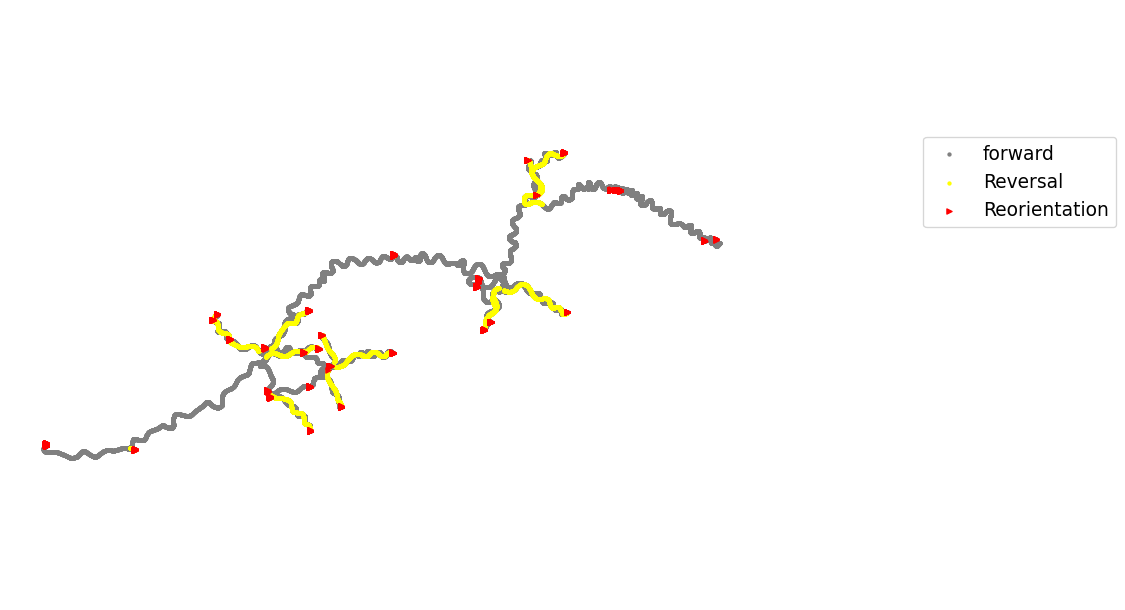

In [31]:
# 根据reorientation和前进后退状态标记线虫的轨迹
fs = 30
df = df_motion_cut_sel  # 标记了forward_sel的运动数据(~30Hz)
fig,ax=plt.subplots(1,1,figsize = (10,8))
plt.axis('equal')
ax.scatter(df['X'], df['Y'], c = 'grey', alpha = 1, s = 5,label='forward')

df_reverse = df[df.forward_sel==1]
ax.scatter(df_reverse['X'], df_reverse['Y'], c = 'yellow', s = 5, label = 'Reversal')
df_reo = df[df.Reorientation==1]
ax.scatter(df_reo['X'], df_reo['Y'], c = 'red', s = 15,marker='>', label = 'Reorientation')
plt.tick_params(labelsize = fs*0.75, pad = fs*0.75)
ax.set_xlabel('X(mm)',fontsize=fs)
ax.set_ylabel('Y(mm)',fontsize=fs)
plt.legend(loc='upper right', bbox_to_anchor = (1.5, 0.8))
plt.axis(False)
plt.show()

In [17]:
# 画所有PC和行为组合的相关性

fs = 20
folder = r'Z:\data space+\C. elegans chemotaxis\20241223_WBI\121906fig'
pc_cols = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
x_cols = ['X','Vol_time', 'speed', 'agl_speed','CTX_left','Reorientation']
for i,pc in enumerate(pc_cols):
    for j, x_col in enumerate(x_cols):
        plt.figure(figsize = (20,5))
        plt.scatter(df_nt_mx[x_col], df_nt_mx[pc])
        plt.xlabel(x_col, fontsize = fs)
        plt.ylabel(pc, fontsize = fs)
        filename = pc+'-'+x_col
        plt.savefig(os.path.join(folder,filename))

NameError: name 'df_nt_mx' is not defined

<Figure size 1920x480 with 0 Axes>

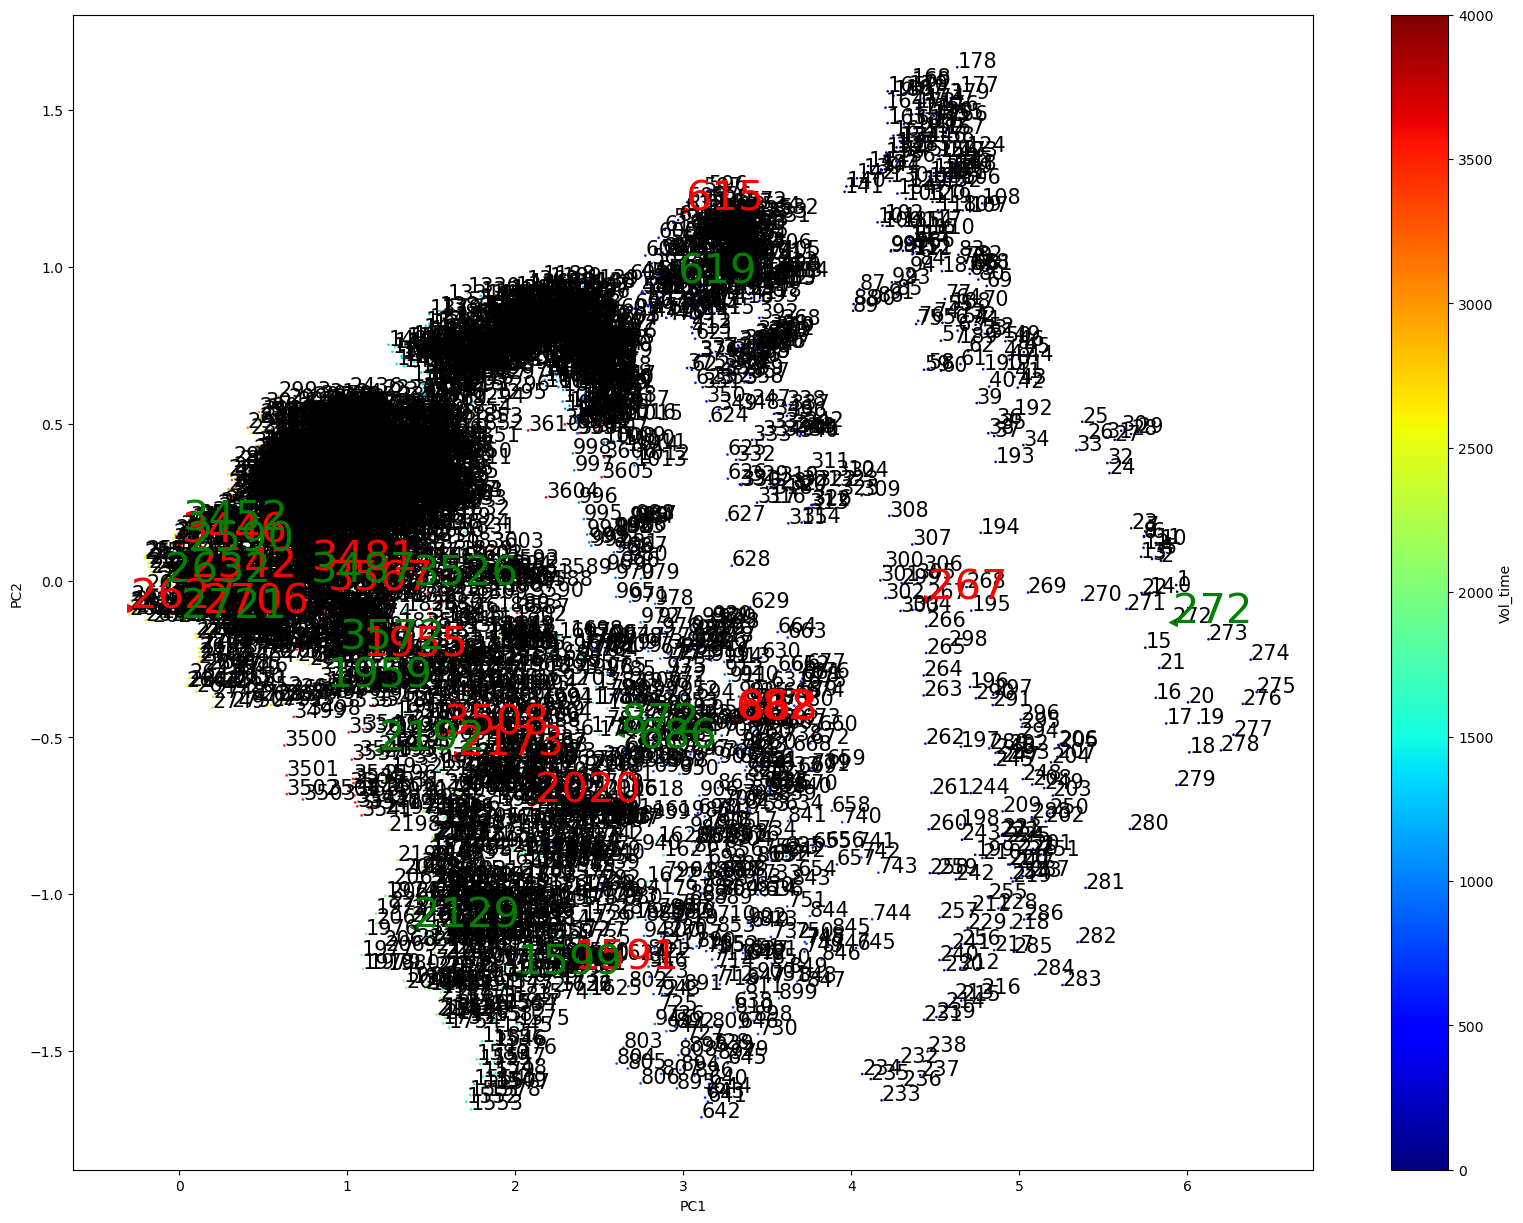

In [317]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (20,15))
fs = 30
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx.index,cmap='jet', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]

ls_all_idx = list(df_nt_mx.index)
str_all_ls_idx = list(map(str,ls_all_idx))

for x, y, text in zip(df_nt_mx['PC1'], df_nt_mx['PC2'], str_all_ls_idx):
    plt.text(x, y, text, color='k', fontsize=fs*0.5)

df_nt_end = df_nt_mx.loc[end_indices]
ls_s_idx = list(df_nt_start.index)
str_s_ls_idx = list(map(str,ls_s_idx))
for x, y, text in zip(df_nt_start['PC1'], df_nt_start['PC2'], str_s_ls_idx):
    plt.text(x, y, text, color='r', fontsize=fs)

ls_e_idx = list(df_nt_end.index)
str_e_ls_idx = list(map(str,ls_e_idx))
for x, y, text in zip(df_nt_end['PC1'], df_nt_end['PC2'], str_e_ls_idx):
    plt.text(x, y, text, color='g', fontsize=fs)    

start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=fs, marker='>', c = 'r')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=fs, marker='<', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


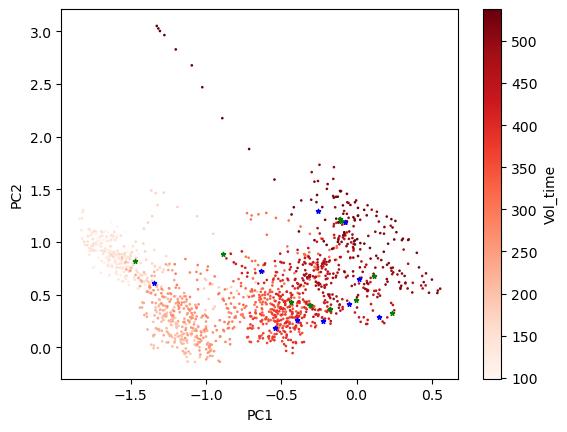

In [80]:

fig, ax = plt.subplots()
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx[label],cmap='Reds', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]
df_nt_end = df_nt_mx.loc[end_indices]
start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=10, marker='*', c = 'b')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=10, marker='*', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [181]:
import matplotlib.colors as mcolors
# PC可视化
# pos_col = 'CTX_left'
nt_col = 'CTX_left'
x_label = pos_col
fs = 25
start = 3000
end=4000
df_nt_t = df_nt.loc[start:end,:]
# 可视化 PC1，颜色根据归一化 'X' 值设置
plt.figure(figsize=(15, 10), dpi=1000)
scatter = plt.scatter(df_nt_t.X, df_nt_t.Y,c = df_nt_t[nt_col], cmap='jet', s=2)
bar = plt.colorbar(scatter)  # 添加 colorbar 和标签
bar.ax.tick_params(labelsize=fs*0.5)
bar.set_label(label=nt_col, fontsize=fs*0.75)
plt.title(f'Trajectory label with{nt_col}from{start}to{end} ', fontsize=fs, pad = 20)
plt.xticks(fontsize=fs*0.5)
plt.yticks(fontsize=fs*0.5)
plt.xlabel('X(mm)', fontsize=fs*0.85)
ax = plt.gca()
ax.set_aspect(1)
plt.ylabel('Y(mm)', fontsize=fs*0.85)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.show()

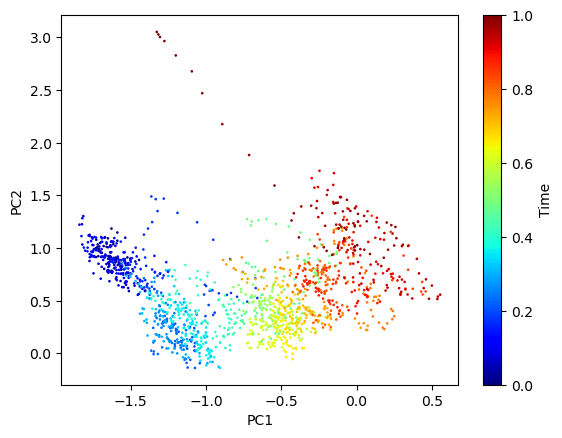

In [200]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
# colors = np.linspace(0, 1, 4001)
# cmap = ListedColormap(['red', 'blue'])
cmp=plt.get_cmap('jet') 
lin=np.linspace(0, 1, calcium_intensity.shape[1])
colors=cmp(lin)
t=calcium_intensity.shape[1]

fig, ax = plt.subplots()

# 绘制散点图，并返回散点图对象
sc = ax.scatter(xn[:t, 0], xn[:t, 1], c=colors[:t], s=0.8)
sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
cbar = fig.colorbar(sm, ax=ax, label='Time')
plt.xlabel('PC1')
plt.ylabel('PC2')
# cbar.set_ticks(np.linspace(0, 1, 20))  # 设置颜色条的刻度
# cbar.set_ticklabels(np.linspace(0, 1, 20)) 
# plt.colorbar(ax.collections[0],label='Time')
# plt.savefig(f'{save_p}/2d_pca.png')
plt.show()


Text(0, 0.5, 'PC1')

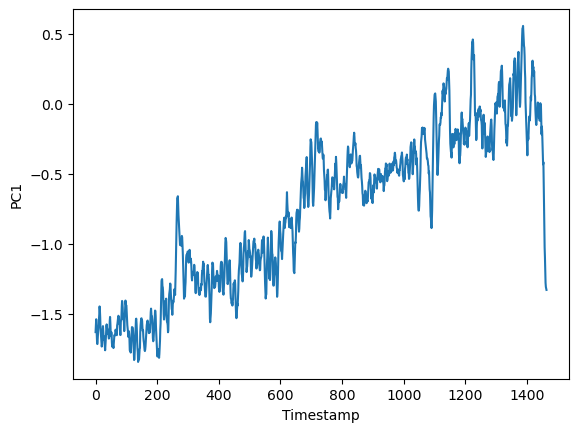

In [205]:
plt.plot(xn[:t,0])
plt.xlabel('Timestamp')
plt.ylabel('PC1')

Text(0.5, 0, 'PC3')

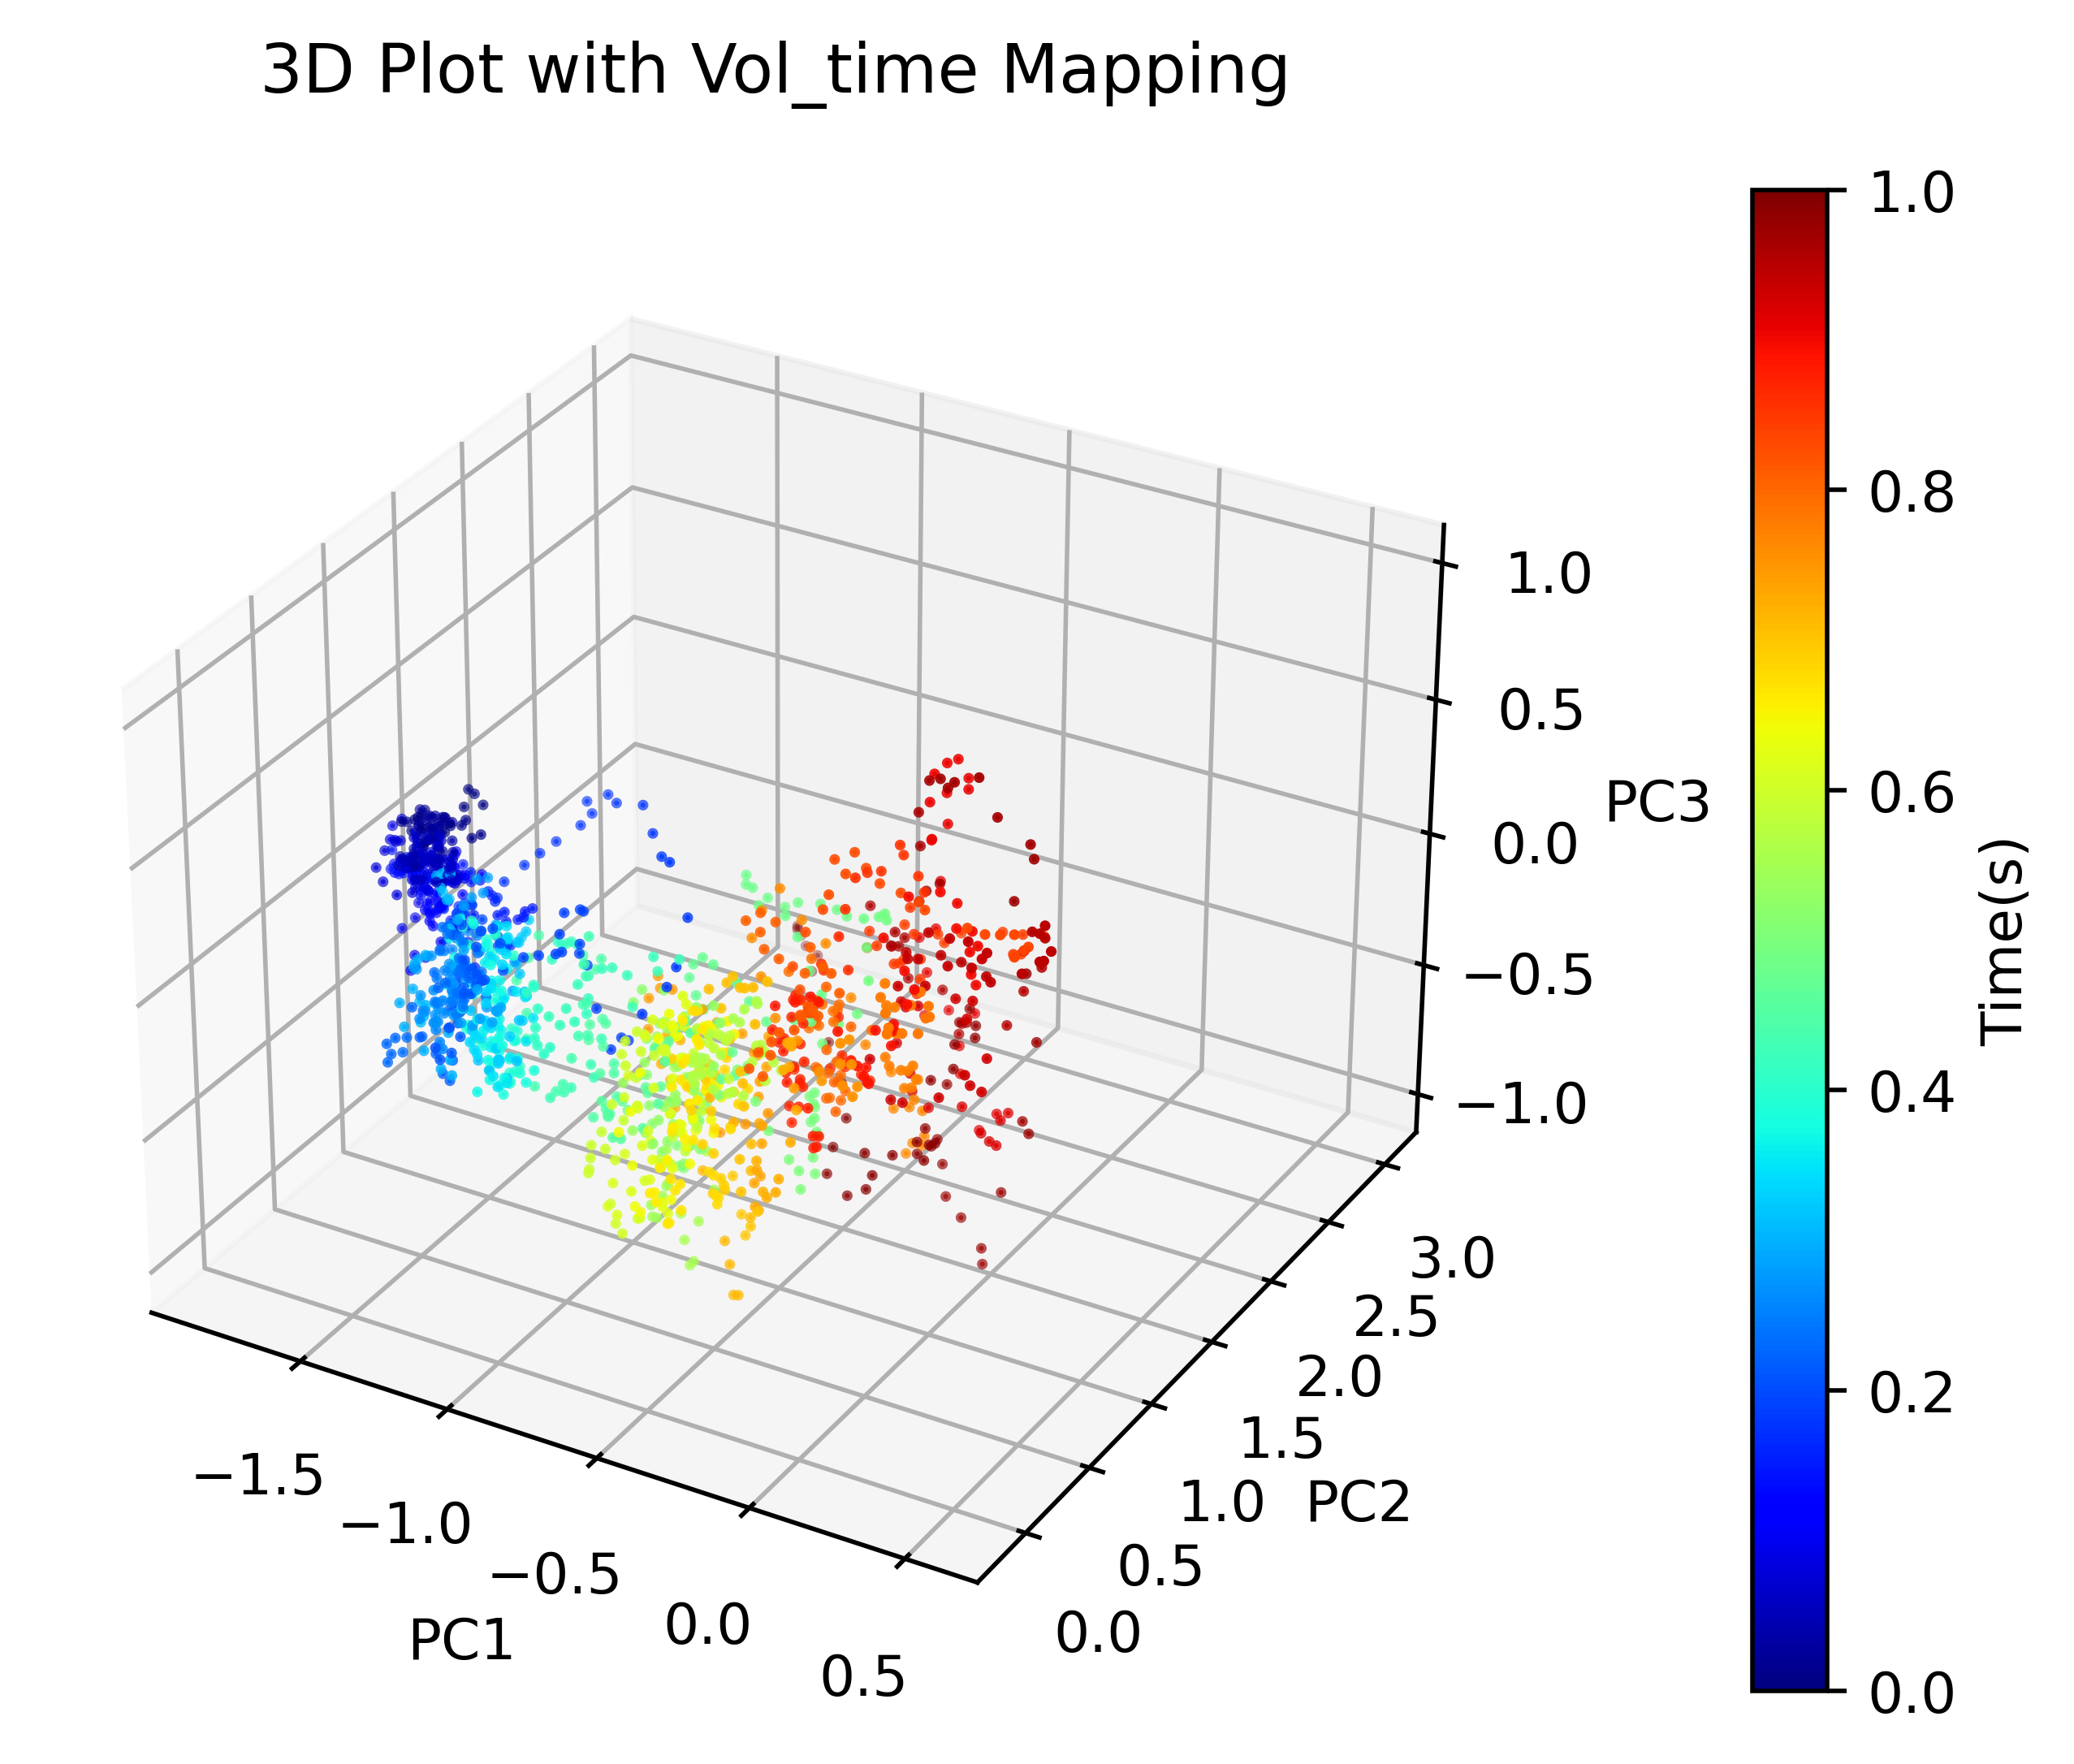

In [208]:
from mpl_toolkits.mplot3d import Axes3D

col = 'Vol_time'
x = xn[:t, 0]
y = xn[:t, 1]
z = xn[:t, 2]
color_values = lin[:t]  # 获取对应的颜色值

# 绘图
fig = plt.figure(dpi=500)
ax = fig.add_subplot(projection='3d')

# 使用 scatter 绘制带颜色的 3D 点
scatter = ax.scatter(x, y, z, c=color_values, cmap='jet', marker='o', s=0.8)

# 添加 colorbar
cbar = plt.colorbar(scatter, ax=ax, pad = 0.12)
cbar.set_label('Time(s)')

# 设置标题和标签
ax.set_title(f'3D Plot with {col} Mapping', pad=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')